In [46]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [47]:
# Step 1: Fetch Data from API
# Define the base API URL
api_url = "https://data.cdc.gov/resource/ua7e-t2fy.json"

query_params = {
    "$where": "weekendingdate >= '2019-01-01'",  # Adjust the start date as needed
    "$order": "weekendingdate ASC",  # Ensure data is sorted chronologically
    "$limit": 50000  # Fetch a large number of rows
}

# Fetch data
response = requests.get(api_url, params=query_params)

if response.status_code == 200:
    data = response.json()
    df = pd.DataFrame(data)
    print("Data fetched successfully.")
else:
    print(f"Failed to fetch data. Status code: {response.status_code}")

# Convert 'weekendingdate' to datetime
df['weekendingdate'] = pd.to_datetime(df['weekendingdate'])

# Display the first few rows
print(df.head())


Data fetched successfully.
  weekendingdate jurisdiction numinptbeds numinptbedsadult numinptbedsped  \
0     2020-08-08           AK      2387.0           432.14           40.0   
1     2020-08-08           AL    22992.29         18227.55         816.93   
2     2020-08-08           AR     7076.94          5305.89        1122.22   
3     2020-08-08           AS         NaN              NaN            NaN   
4     2020-08-08           AZ     8085.81          5670.88         133.43   

  numinptbedsocc numinptbedsoccadult numinptbedsoccped numicubeds  \
0        1615.43              533.69             87.93     370.86   
1       17096.08            14409.08            439.24    3643.29   
2        4592.58             4015.78            389.73     1311.8   
3            NaN                 NaN               NaN        NaN   
4        8407.47             6452.59            381.46    2210.71   

  numicubedsadult  ... numconfflunewadmadult18to49per100k  \
0            45.0  ...            

In [48]:
print(df['weekendingdate'].min(), df['weekendingdate'].max())

2020-08-08 00:00:00 2024-12-28 00:00:00


In [49]:
# Step 2: Inspect Data Structure
print("Columns in the dataset:", df.columns)
print("First few rows of the dataset:")
print(df.head())

Columns in the dataset: Index(['weekendingdate', 'jurisdiction', 'numinptbeds', 'numinptbedsadult',
       'numinptbedsped', 'numinptbedsocc', 'numinptbedsoccadult',
       'numinptbedsoccped', 'numicubeds', 'numicubedsadult',
       ...
       'numconfflunewadmadult18to49per100k',
       'numconfflunewadmadult50to64per100k',
       'numconfflunewadmadult65to74per100k',
       'numconfflunewadmadult75plusper100k', 'numconfrsvnewadmped0to4per100k',
       'numconfrsvnewadmped5to17per100k', 'numconfrsvnewadmadult18to49per100k',
       'numconfrsvnewadmadult50to64per100k',
       'numconfrsvnewadmadult65to74per100k',
       'numconfrsvnewadmadult75plusper100k'],
      dtype='object', length=190)
First few rows of the dataset:
  weekendingdate jurisdiction numinptbeds numinptbedsadult numinptbedsped  \
0     2020-08-08           AK      2387.0           432.14           40.0   
1     2020-08-08           AL    22992.29         18227.55         816.93   
2     2020-08-08           AR     70

In [50]:
# Select relevant columns for analysis
columns_to_keep = ['weekendingdate', 'jurisdiction', 
                   'numinptbeds', 'numinptbedsocc', 
                   'numicubeds','numconfflunewadmadult18to49per100k',
                   'numconfflunewadmadult50to64per100k',
                   'numconfflunewadmadult65to74per100k',
                   'numconfflunewadmadult75plusper100k']
df = df[columns_to_keep]

# Convert numeric columns to appropriate data types
numeric_columns = ['numinptbeds', 'numinptbedsocc', 'numicubeds']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values in critical columns
df = df.dropna(subset=numeric_columns)

# Check the cleaned dataset
print("Cleaned Dataset:")
print(df.info())


Cleaned Dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 12857 entries, 0 to 13109
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   weekendingdate                      12857 non-null  datetime64[ns]
 1   jurisdiction                        12857 non-null  object        
 2   numinptbeds                         12857 non-null  float64       
 3   numinptbedsocc                      12857 non-null  float64       
 4   numicubeds                          12857 non-null  float64       
 5   numconfflunewadmadult18to49per100k  662 non-null    object        
 6   numconfflunewadmadult50to64per100k  662 non-null    object        
 7   numconfflunewadmadult65to74per100k  662 non-null    object        
 8   numconfflunewadmadult75plusper100k  662 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 1004.5+ KB
None


In [51]:
# Step 3: Preprocess Data
# Convert 'weekendingdate' to datetime
df['weekendingdate'] = pd.to_datetime(df['weekendingdate'])

# Select relevant numeric columns for analysis
numeric_columns = ['numinptbeds', 'numicubeds', 'numinptbedsocc']

# Convert numeric columns to appropriate data types
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing data in these columns
df = df.dropna(subset=numeric_columns)

print("Cleaned dataset info:")
print(df.info())

Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 12857 entries, 0 to 13109
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   weekendingdate                      12857 non-null  datetime64[ns]
 1   jurisdiction                        12857 non-null  object        
 2   numinptbeds                         12857 non-null  float64       
 3   numinptbedsocc                      12857 non-null  float64       
 4   numicubeds                          12857 non-null  float64       
 5   numconfflunewadmadult18to49per100k  662 non-null    object        
 6   numconfflunewadmadult50to64per100k  662 non-null    object        
 7   numconfflunewadmadult65to74per100k  662 non-null    object        
 8   numconfflunewadmadult75plusper100k  662 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 1004.5+ KB
None


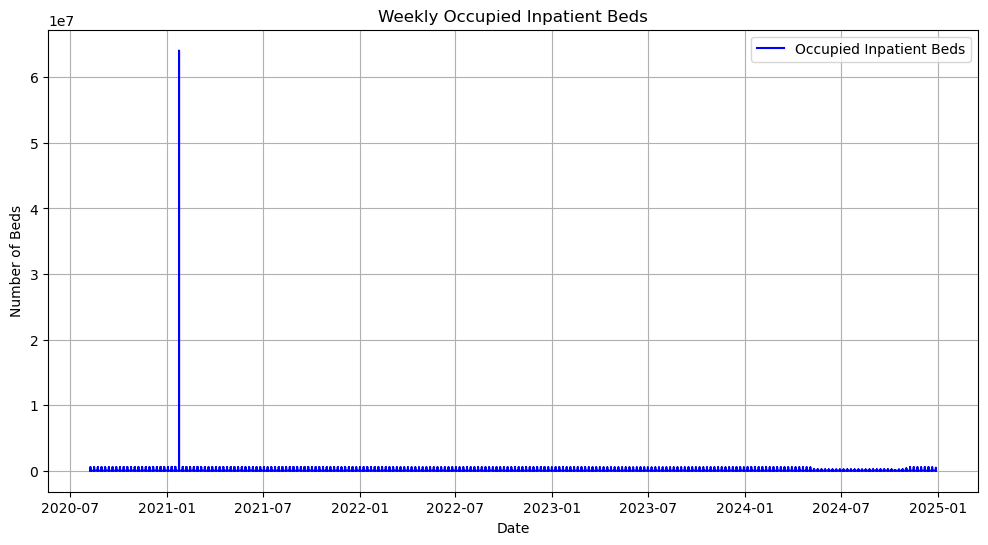

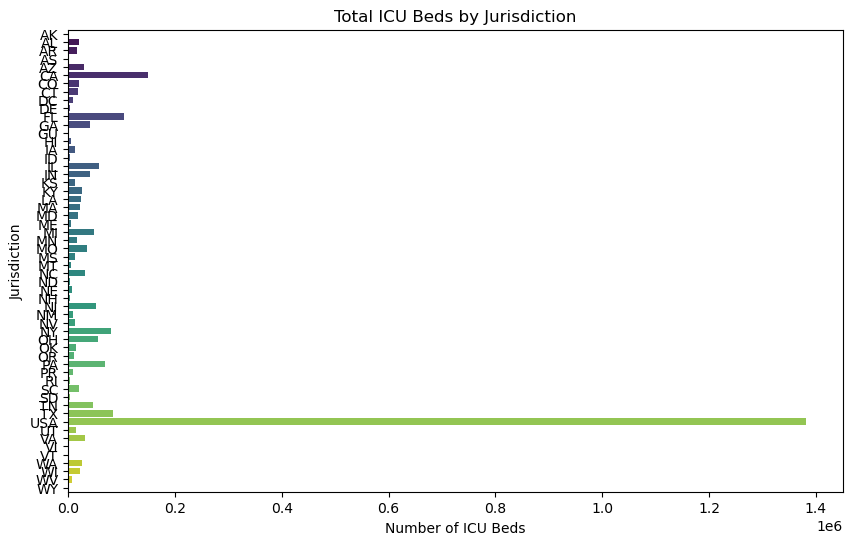

In [52]:
# Step 4: Exploratory Data Analysis (EDA)
# Plot total occupied inpatient beds over time
plt.figure(figsize=(12, 6))
plt.plot(df['weekendingdate'], df['numinptbedsocc'], label='Occupied Inpatient Beds', color='blue')
plt.title("Weekly Occupied Inpatient Beds")
plt.xlabel("Date")
plt.ylabel("Number of Beds")
plt.legend()
plt.grid()
plt.show()

# Bar plot for ICU bed counts by jurisdiction (as an example of categorical grouping)
plt.figure(figsize=(10, 6))
sns.barplot(x='numicubeds', y='jurisdiction', data=jurisdiction_data, hue='jurisdiction', dodge=False, palette='viridis')
plt.title("Total ICU Beds by Jurisdiction")
plt.xlabel("Number of ICU Beds")
plt.ylabel("Jurisdiction")
plt.legend([], [], frameon=False)  # Remove extra legend added by hue
plt.show()


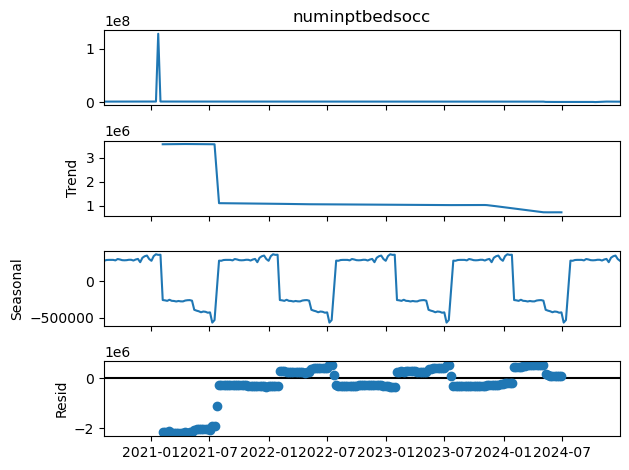

In [53]:
# Step 5: Time Series Analysis
# Aggregate data by week for a numeric column
weekly_data = df.groupby('weekendingdate')['numinptbedsocc'].sum()

# Decompose the time series
decomposition = seasonal_decompose(weekly_data, model='additive', period=52)
decomposition.plot()
plt.show()

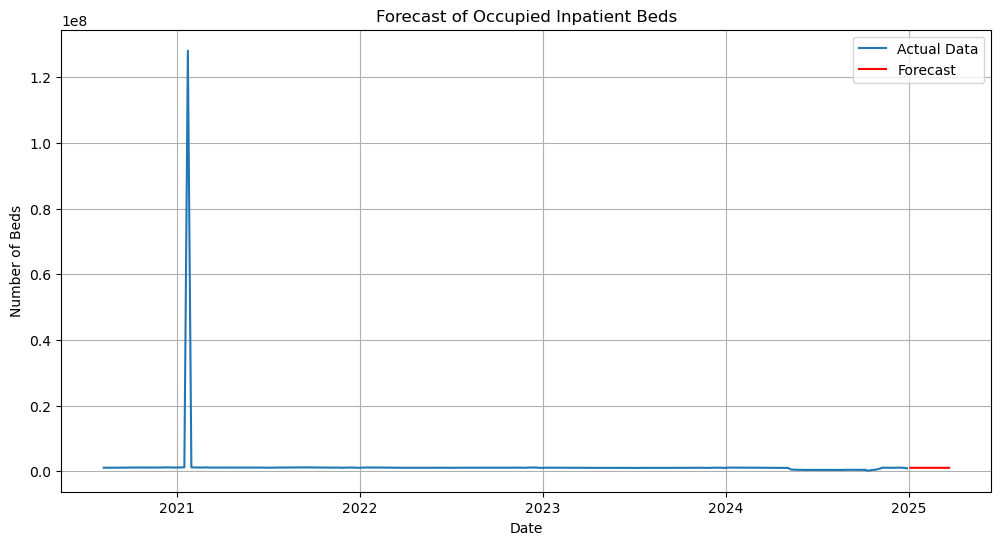

In [54]:
# Step 6: Predictive Modeling with ARIMA
# Train ARIMA model
# Ensure the index of weekly_data has a defined frequency
weekly_data.index = pd.date_range(start=weekly_data.index[0], end=weekly_data.index[-1], freq='W-SAT')

# Fit an ARIMA model
model = ARIMA(weekly_data, order=(2, 1, 2))  # Adjust order as needed
model_fit = model.fit()

# Forecast future values
forecast = model_fit.forecast(steps=12)

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(weekly_data, label="Actual Data")
plt.plot(forecast, label="Forecast", color="red")
plt.title("Forecast of Occupied Inpatient Beds")
plt.xlabel("Date")
plt.ylabel("Number of Beds")
plt.legend()
plt.grid()
plt.show()


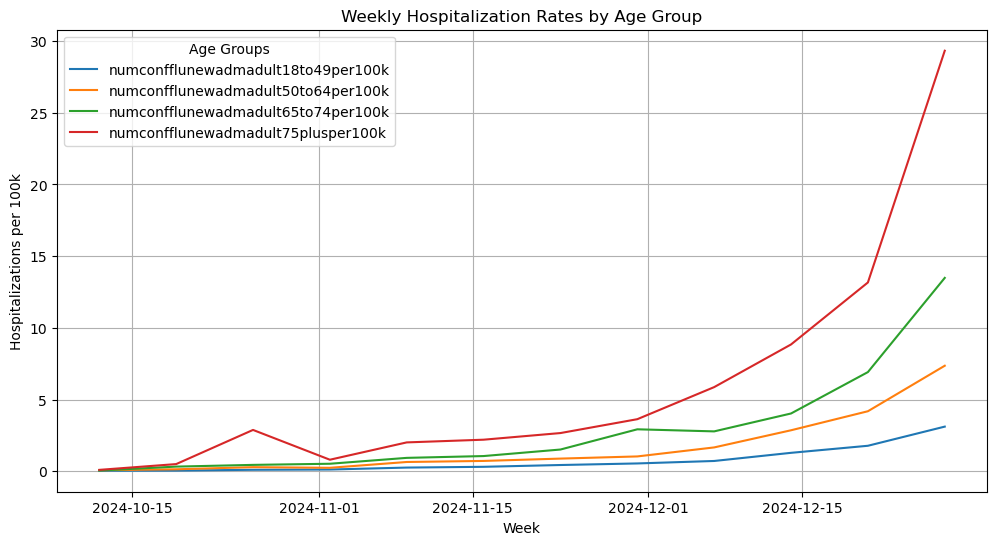

In [55]:
import matplotlib.pyplot as plt

# Define age group columns for analysis
age_group_columns = [
    'numconfflunewadmadult18to49per100k',
    'numconfflunewadmadult50to64per100k',
    'numconfflunewadmadult65to74per100k',
    'numconfflunewadmadult75plusper100k'
]

# Ensure numeric conversion for age-specific columns
for col in age_group_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Aggregate age group data by week
age_group_data = df.groupby('weekendingdate')[age_group_columns].mean()

# Plot age-specific hospitalization trends
plt.figure(figsize=(12, 6))
for col in age_group_columns:
    plt.plot(age_group_data.index, age_group_data[col], label=col)

plt.title("Weekly Hospitalization Rates by Age Group")
plt.xlabel("Week")
plt.ylabel("Hospitalizations per 100k")
plt.legend(title="Age Groups")
plt.grid()
plt.show()


In [56]:
# Step 7: Save Cleaned Data and Results
# Save cleaned data to CSV
df.to_csv("cleaned_hospital_data.csv", index=False)

# Save forecast results
forecast_df = pd.DataFrame({'Forecast': forecast})
forecast_df.to_csv("hospital_forecast.csv", index=False)

print("Data and forecast saved successfully.")

Data and forecast saved successfully.


**Additional Notes
Insights:

Use the seasonal decomposition plot to observe long-term trends and seasonal patterns (e.g., increases during winter months).
Compare forecasted values against the recent trend to validate predictions.
Enhancements:

Incorporate other columns like ICU beds or jurisdiction-level trends for a more detailed analysis.
Use advanced forecasting models (e.g., SARIMA, Prophet) for better seasonality handling.**